<a href="https://colab.research.google.com/github/rahiakela/cs231n-convolutional-neural-networks-for-visual-recognition/blob/master/module-1-neural-networks/8_putting_it_together_minimal_neural_network_case_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Putting it together: Minimal Neural Network Case Study

Table of Contents:

- Generating some data
- Training a Softmax Linear Classifier
 - Initialize the parameters
 - Compute the class scores
 - Compute the loss
 - Computing the analytic gradient with backpropagation
 - Performing a parameter update
 - Putting it all together: Training a Softmax Classifier
- Training a Neural Network
- Summary

In this section we’ll walk through a complete implementation of a toy Neural Network in 2 dimensions. We’ll first implement a simple linear classifier and then extend the code to a 2-layer Neural Network. As we’ll see, this extension is surprisingly simple and very few changes are necessary.

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Generating some data

Lets generate a classification dataset that is not easily linearly separable. Our favorite example is the spiral dataset, which can be generated as follows:

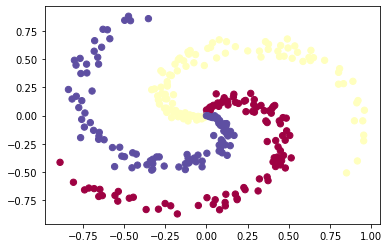

In [5]:
np.random.seed(0)

N = 100    # number of points per class
D = 2      # dimensionality
K = 3      # number of classes

# data matrix (each row = single example)
X = np.zeros(( N * K, D))
# class labels
y = np.zeros(N * K, dtype='uint8')

for j in range(K):
  xi = range(N * j, N * (j + 1))
  r = np.linspace(0.0, 1, N)  # radius
  t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * 0.2   # theta
  X[xi] = np.c_[r * np.sin(t), r * np.cos(t)]
  y[xi] = j

# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

> The toy spiral data consists of three classes (blue, red, yellow) that are not linearly separable.

---

Normally we would want to preprocess the dataset so that each feature has zero mean and unit standard deviation, but in this case the features are already in a nice range from -1 to 1, so we skip this step.

## Training a Softmax Linear Classifier

### Initialize the parameters

Lets first train a Softmax classifier on this classification dataset. As we saw in the previous sections, the Softmax classifier has a linear score function and uses the cross-entropy loss. The parameters of the linear classifier consist of a weight matrix $W$ and a bias vector $b$ for each class. Lets first initialize these parameters to be random numbers:

In [25]:
# initialize parameters randomly
W = 0.01 * np.random.randn(D, K)
b = np.zeros((1, K))
# regularization strength
reg = 1e-3 
step_size = 1e-0

Recall that we $D = 2$ is the dimensionality and $K = 3$ is the number of classes.

### Compute the class scores

Since this is a linear classifier, we can compute all class scores very simply in parallel with a single matrix multiplication:

In [9]:
# compute class scores for a linear classifier
scores = np.dot(X, W) + b
scores[:5]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-8.40629644e-05,  8.69466095e-05, -4.76342715e-05],
       [-2.04256892e-04,  2.20970493e-04, -9.60559865e-05],
       [-3.87042332e-04,  4.40962833e-04, -1.36889794e-04],
       [-5.05598490e-04,  5.73248628e-04, -1.84472983e-04]])

In this example we have 300 2-D points, so after this multiplication the array `scores` will have size `[300 x 3]`, where each row gives the class scores corresponding to the 3 classes (blue, red, yellow).

### Compute the loss

The second key ingredient we need is a loss function, which is a differentiable objective that quantifies our unhappiness with the computed class scores. Intuitively, we want the correct class to have a higher score than the other classes. When this is the case, the loss should be low and otherwise the loss should be high. There are many ways to quantify this intuition, but in this example lets use the cross-entropy loss that is associated with the Softmax classifier. Recall that if $f$ is the array of class scores for a single example (e.g. array of 3 numbers here), then the Softmax classifier computes the loss for that example as:

$$ L_i = -\log\left(\frac{e^{f_{y_i}}}{ \sum_j e^{f_j} }\right) $$

We can see that the Softmax classifier interprets every element of $f$ as holding the (unnormalized) log probabilities of the three classes. We exponentiate these to get (unnormalized) probabilities, and then normalize them to get probabilites. Therefore, the expression inside the log is the normalized probability of the correct class. Note how this expression works: this quantity is always between 0 and 1. When the probability of the correct class is very small (near 0), the loss will go towards (positive) infinity. Conversely, when the correct class probability goes towards 1, the loss will go towards zero because $log(1)=0$. Hence, the expression for $L_i$ is low when the correct class probability is high, and it’s very high when it is low.

Recall also that the full Softmax classifier loss is then defined as the average cross-entropy loss over the training examples and the regularization:

$$ L =  \underbrace{ \frac{1}{N} \sum_i L_i }_\text{data loss} + \underbrace{ \frac{1}{2} \lambda \sum_k\sum_l W_{k,l}^2 }_\text{regularization loss} \\\\ $$

Given the array of `scores` we’ve computed above, we can compute the loss. First, the way to obtain the probabilities is straight forward:


In [13]:
num_examples = X.shape[0]

# get unnormalized probabilities
exp_scores = np.exp(scores)

# normalize them for each example
probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
print('Shape: ', probs.shape)
probs[:5]

Shape:  (300, 3)


array([[0.33333333, 0.33333333, 0.33333333],
       [0.33331028, 0.33336729, 0.33332243],
       [0.33327406, 0.33341581, 0.33331013],
       [0.33321354, 0.33348956, 0.3332969 ],
       [0.33317778, 0.33353742, 0.33328479]])

We now have an array `probs` of size `[300 x 3]`, where each row now contains the class probabilities. In particular, since we’ve normalized them every row now sums to one. We can now query for the log probabilities assigned to the correct classes in each example:

In [14]:
correct_logprobs = - np.log(probs[range(num_examples), y])
print('Shape: ', correct_logprobs.shape)
correct_logprobs[:5]

Shape:  (300,)


array([1.09861229, 1.09868144, 1.09879011, 1.09897173, 1.09907905])

The array `correct_logprobs` is a 1D array of just the probabilities assigned to the correct classes for each example. The full loss is then the average of these log probabilities and the regularization loss:

In [19]:
# compute the loss: average cross-entropy loss and regularization
data_loss = np.sum(correct_logprobs) / num_examples
reg_loss = 0.5 * reg * np.sum(W * W)
loss = data_loss + reg_loss
print('Shape: ', loss.shape)
loss

Shape:  ()


1.096919424803858

In this code, the regularization strength $λ$ is stored inside the `reg`. The convenience factor of `0.5` multiplying the regularization will become clear in a second. Evaluating this in the beginning (with random parameters) might give us `loss = 1.1`, which is $np.log(1.0/3)$, since with small initial random weights all probabilities assigned to all classes are about one third. We now want to make the loss as low as possible, with `loss = 0` as the absolute lower bound. But the lower the loss is, the higher are the probabilities assigned to the correct classes for all examples.

### Computing the Analytic Gradient with Backpropagation

We have a way of evaluating the loss, and now we have to minimize it. We’ll do so with gradient descent. That is, we start with random parameters (as shown above), and evaluate the gradient of the loss function with respect to the parameters, so that we know how we should change the parameters to decrease the loss. Lets introduce the intermediate variable $p$, which is a vector of the (normalized) probabilities. The loss for one example is:

$$ p_k = \frac{e^{f_k}}{ \sum_j e^{f_j} } \hspace{1in} L_i =-\log\left(p_{y_i}\right) $$

We now wish to understand how the computed scores inside $f$ should change to decrease the loss Li that this example contributes to the full objective. In other words, we want to derive the gradient $∂L_i/∂f_k$. The loss Li is computed from $p$, which in turn depends on $f$. It’s a fun exercise to the reader to use the chain rule to derive the gradient, but it turns out to be extremely simple and interpretible in the end, after a lot of things cancel out:

$$ \frac{\partial L_i }{ \partial f_k } = p_k - \mathbb{1}(y_i = k) $$

Notice how elegant and simple this expression is. Suppose the probabilities we computed were $p = [0.2, 0.3, 0.5]$, and that the correct class was the middle one (with probability 0.3). According to this derivation the gradient on the scores would be $df = [0.2, -0.7, 0.5]$. Recalling what the interpretation of the gradient, we see that this result is highly intuitive: increasing the first or last element of the score vector $f$ (the scores of the incorrect classes) leads to an increased loss (due to the positive signs +0.2 and +0.5) - and increasing the loss is bad, as expected. However, increasing the score of the correct class has negative influence on the loss. The gradient of -0.7 is telling us that increasing the correct class score would lead to a decrease of the loss $L_i$, which makes sense.

All of this boils down to the following code. Recall that `probs` stores the probabilities of all classes (as rows) for each example. To get the gradient on the `scores`, which we call `dscores`, we proceed as follows:

In [22]:
dscores = scores
dscores[range(num_examples), y] -= 1
dscores /= num_examples
print('Shape: ', dscores.shape)
dscores[:5]

Shape:  (300, 3)


array([[-3.34448148e-03,  0.00000000e+00,  0.00000000e+00],
       [-3.34448148e-03,  3.22024480e-12, -1.76423228e-12],
       [-3.34448149e-03,  8.18409233e-12, -3.55762913e-12],
       [-3.34448150e-03,  1.63319568e-11, -5.06999237e-12],
       [-3.34448150e-03,  2.12314306e-11, -6.83233271e-12]])

Lastly, we had that $scores = np.dot(X, W) + b$, so armed with the gradient on scores (stored in dscores), we can now backpropagate into $W$ and $b$:

In [24]:
dW = np.dot(X.T, dscores) 
db = np.sum(dscores, axis=0, keepdims=True)

# don't forget the regularization gradient
dW += reg * W
print('Shape: ', dW.shape)
dW

Shape:  (2, 3)


array([[-0.0362285 , -0.04603512,  0.09504418],
       [ 0.09063567, -0.09275849,  0.02149019]])

Where we see that we have backpropped through the matrix multiply operation, and also added the contribution from the regularization. Note that the regularization gradient has the very simple form $reg*W$ since we used the constant 0.5 for its loss contribution (i.e. $\frac{d}{dw}(\frac{1}{2}λw^2)=λw$). This is a common convenience trick that simplifies the gradient expression.

### Performing a parameter update

Now that we’ve evaluated the gradient we know how every parameter influences the loss function. We will now perform a parameter update in the negative gradient direction to decrease the loss:

In [26]:
# perform a parameter update
W += - step_size * dW
b += - step_size * db
print(W.shape, b.shape)

(2, 3) (1, 3)


### Putting it all together: Training a Softmax Classifier

Putting all of this together, here is the full code for training a Softmax classifier with Gradient descent: